In [1]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import List, Union, Callable, Tuple, Any
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Motivation

Building the model that can effectively decide whether to give a loan or not can help bank to speed up the underwriting process. As the result from [[1]](), with useful information is provided, the model can achieve high performance. However, some information such as income is not accessible at first, and bank normally asks for the proof of income which takes time during the process. As banks, they want to know this before customers provide it to them in order to improve the underwriting process.


In practice, building the sophisticated income model is challenging due to lack of usable features, and so on. Alternatively, managaing/mitigating the uncertainty of the model at least helps bank to tradeoff between risk and profit.

In [2]:
df = pd.read_csv("../data/loan-train.csv")
df.head()
df.shape

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


(614, 13)

In [3]:
df["Loan_Status"] = (df["Loan_Status"] == "Y").astype(int)

## Feature engineering

**Total income**

Applicant income and Coapplicant income can determine the loan amount that customer can take.

In [4]:
df["TotalIncome"] = df["ApplicantIncome"] + df["CoapplicantIncome"]

**Income Bin**

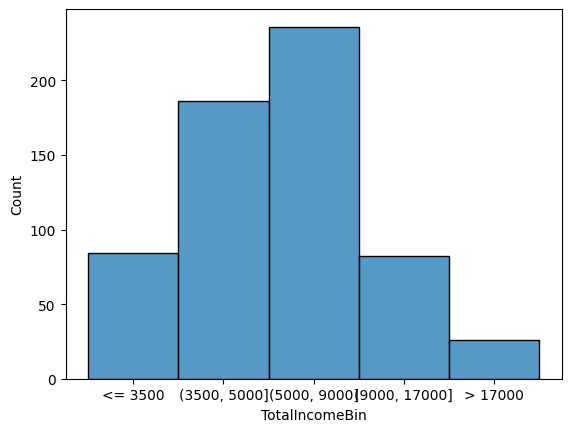

In [5]:
total_income_bin_names = ["<= 3500", "(3500, 5000]", "(5000, 9000]", "(9000, 17000]", "> 17000"]

df["TotalIncomeBin"] = pd.cut(
    df["TotalIncome"], 
    bins=[-np.inf, 3500, 5000, 9000, 17000, np.inf],
    labels=total_income_bin_names
)  # .astype(str)

_ = sns.histplot(df["TotalIncomeBin"])

df["TotalIncomeBin"] = df["TotalIncomeBin"].astype(str)

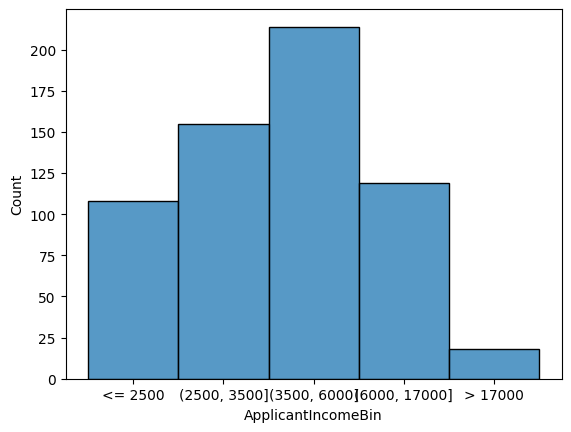

In [41]:
applicant_income_bin_names = ["<= 2500", "(2500, 3500]", "(3500, 6000]", "(6000, 17000]", "> 17000"]

df["ApplicantIncomeBin"] = pd.cut(
    df["ApplicantIncome"], 
    bins=[-np.inf, 2500, 3500, 6000, 17000, np.inf],
    labels=applicant_income_bin_names
)  # .astype(str)

_ = sns.histplot(df["ApplicantIncomeBin"])

df["ApplicantIncomeBin"] = df["ApplicantIncomeBin"].astype(str)

**Monthly payment**[[3]]()

If bank approve the loan, what is the minimum monthly payment?

$$
M = P\frac{r(1+r)^n}{(1+r)^n - 1}
$$

Where, 

$M$ is the monthly payment

$P$ is the mortgage amount

$r$ is the monthly interest rate

$n$ is the number of payment

</br>

In [42]:
def calculate_mortgage_payment_per_month(p: float, r: float = 0.06/12, n: int = 360) -> float:
    """
    Calcuate the mortgage payment per month
    
    Args:
        p: mortgage amount
        r: monthly interest rate (default 6% per year)
        n: number of payment (default 360)
        
    Returns:
        monthly per month
    """
    
    numerator = r * (1 + r) ** n
    denominator = (1 + r) ** n - 1
    res = p * numerator / denominator
    return res

In [43]:
df["MonthlyPayment"] = list(map(
    lambda p: calculate_mortgage_payment_per_month(p * 1_000), df["LoanAmount"]
))

**Expected profit**

In [44]:
df["TotalPay"] = df["MonthlyPayment"] * 360
df["ExpectedProfit"] = df["TotalPay"] - (df["LoanAmount"] * 1_000)

In [45]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,TotalIncomeBin,ApplicantIncomeBin,MonthlyPayment,TotalPay,ExpectedProfit
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,1,5849.0,"(5000, 9000]","(3500, 6000]",NaN,NaN,NaN
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0,6091.0,"(5000, 9000]","(3500, 6000]",767.424672,276272.881990,148272.881990
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1,3000.0,<= 3500,"(2500, 3500]",395.703347,142453.204776,76453.204776
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1,4941.0,"(3500, 5000]","(2500, 3500]",719.460630,259005.826866,139005.826866
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1,6000.0,"(5000, 9000]","(3500, 6000]",845.366240,304331.846568,163331.846568


## Baseline loan model

Let's build the baseline for loan approval model.

In [46]:
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import PowerTransformer, OneHotEncoder

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold

In [47]:
def safe_df(df: Any, cols: List[str] = None) -> pd.DataFrame:
    if isinstance(df, scipy.sparse._csr.csr_matrix):
        df = df.toarray()
    if not isinstance(df, pd.DataFrame):
        df = pd.DataFrame(df, columns=cols)
    return df.reset_index(drop=True)


def encode_categorical_features(df: pd.DataFrame, feature_cols: List[str], target_col: str) -> Tuple[pd.DataFrame, ...]:
    if not feature_cols:
        return None, None
    df_encoded = df.copy()
    encoder = TargetEncoder()
    df_encoded = encoder.fit_transform(df_encoded[feature_cols], df_encoded[target_col])
    return safe_df(df_encoded, feature_cols), encoder


## One-hot
def encode_categorical_features_v2(df: pd.DataFrame, feature_cols: List[str], target_col: str = None) -> Tuple[pd.DataFrame, ...]:
    if not feature_cols:
        return None, None
    df_encoded = df.copy()
    encoder = OneHotEncoder()
    df_encoded = encoder.fit_transform(df_encoded[feature_cols])
    return safe_df(df_encoded), encoder


def encode_numerical_features(df: pd.DataFrame, feature_cols: List[str]) -> Tuple[pd.DataFrame, ...]:
    if not feature_cols:
        return None, None
    df_encoded = df.copy()
    encoder = PowerTransformer()
    df_encoded = encoder.fit_transform(df_encoded[feature_cols])
    return safe_df(df_encoded, feature_cols), encoder


def apply_encoder(df: pd.DataFrame, enc: Union[TargetEncoder, PowerTransformer], feature_cols: List[str]) -> pd.DataFrame:
    if not feature_cols:
        return None
    df_encoded = df.copy()
    df_encoded = enc.transform(df_encoded[feature_cols])
    return safe_df(df_encoded, cols=feature_cols if df_encoded.shape[1] == len(feature_cols) else None)

In [48]:
def rollout_result(
    model_fn: Callable, 
    df: pd.DataFrame,
    cat_features: List[str],
    num_features: List[str],
    target: str,
    metric_fn: Callable = accuracy_score,
    use_onehot: bool = False,
    n_splits: int = 5,
    seed: int = 123
) -> Tuple[float, ...]:
    
    df_copy = df.copy()
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    scores = []
    models = []

    for train_idx, test_idx in kf.split(df_copy):
        train_df, test_df = df_copy.iloc[train_idx].reset_index(drop=True), df_copy.iloc[test_idx].reset_index(drop=True)

        # encode training set
        if use_onehot:
            train_encoded_cat, cat_encoder = encode_categorical_features_v2(train_df, cat_features, target)
        else:
            train_encoded_cat, cat_encoder = encode_categorical_features(train_df, cat_features, target)
        train_encoded_num, num_encoder = encode_numerical_features(train_df, num_features)
        train_encoded = pd.concat([train_encoded_cat, train_encoded_num, train_df[[target]]], axis=1)

        # train the model
        model = model_fn()
        _ = model.fit(train_encoded.drop(target, axis=1), train_encoded[target])

        # encode testing set
        test_encoded_cat = apply_encoder(test_df, cat_encoder, cat_features)
        test_encoded_num = apply_encoder(test_df, num_encoder, num_features)
        test_encoded = pd.concat([test_encoded_cat, test_encoded_num, test_df[[target]]], axis=1)
        
        # evaluate
        pred = model.predict(test_encoded.drop(target, axis=1))
        y_true = test_encoded[[target]]
        
        scores.append(metric_fn(y_true, pred))
        models.append(model)

    best_idx = np.argmax(scores)
        
    return np.mean(scores), models[best_idx]

In [49]:
df_copy = df.dropna().copy()

In [50]:
mean_scores, best_model = rollout_result(
    model_fn=lambda: CatBoostClassifier(iterations=1e3, depth=5, verbose=0),
    df=df_copy,
    cat_features=[
        "Gender", "Married", "Dependents", "Education", 
        "Self_Employed", "Property_Area", "Credit_History"
    ],
    num_features=[
        "ApplicantIncome", "TotalIncome", "LoanAmount", "Loan_Amount_Term", 
        "MonthlyPayment",
    ],
    target="Loan_Status"
)

/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See 

In [51]:
mean_scores

0.80625

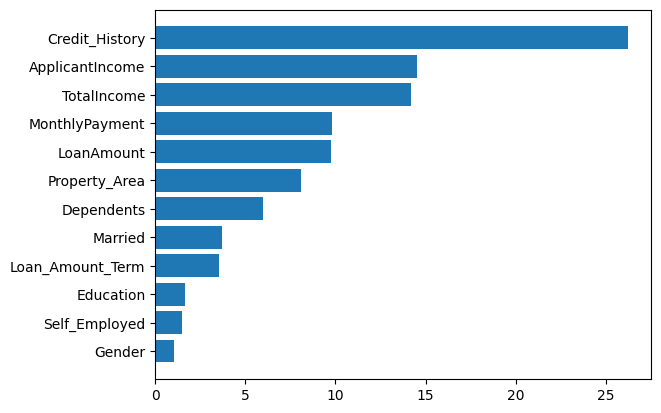

In [52]:
idx = np.argsort(best_model.feature_importances_)
_ = plt.barh(np.array(best_model.feature_names_)[idx], np.array(best_model.feature_importances_)[idx])

As the result, **ApplicantIncome** is in the top 3 important features. Let's see if we drop all income-related features out.

In [53]:
mean_scores, best_model = rollout_result(
    model_fn=lambda: CatBoostClassifier(iterations=1e3, depth=5, verbose=0),
    df=df_copy,
    cat_features=[
        "Gender", "Married", "Dependents", "Education", 
        "Self_Employed", "Property_Area", "Credit_History"
    ],
    num_features=[],
    target="Loan_Status"
)

/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See 

In [54]:
mean_scores

0.7770833333333333

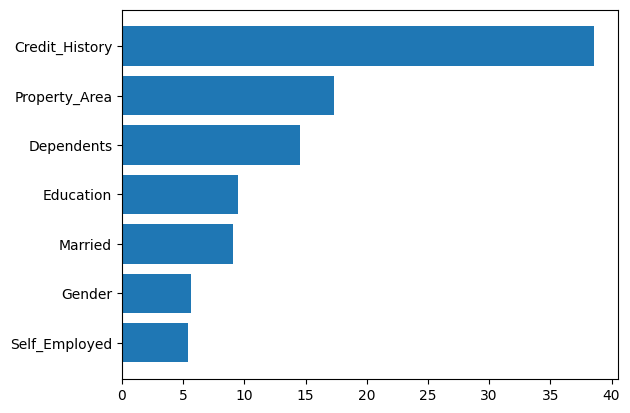

In [55]:
idx = np.argsort(best_model.feature_importances_)
_ = plt.barh(np.array(best_model.feature_names_)[idx], np.array(best_model.feature_importances_)[idx])

Obviously, removing the income-related features affects the performance of the model. 

## Proxy Income

### Quantile regression

In [142]:
from sklearn.linear_model import QuantileRegressor
from sklearn.metrics import mean_squared_error


class QuantileRegression:
    def __init__(self, q: List[float] = [0.05, 0.5, 0.95]):
        self.q_levels = q
        self.models = {}
        
    def fit(self, X, y):
        for q in self.q_levels:
            self.models[q] = QuantileRegressor(quantile=q)
            self.models[q].fit(X, y)

    def predict(self, X, median=True) -> np.ndarray:
        preds = []
        for q in self.q_levels:
            pred = self.models[q].predict(X)
            preds.append(pred.reshape((-1, 1)))
        preds = np.concatenate(preds, axis=1)
        return preds[:, 1] if median else preds

In [146]:
train, test = train_test_split(df_copy, test_size=0.2, random_state=123)    

train_encoded, encoder = encode_categorical_features(
    train, 
    ["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area"], 
    "ApplicantIncome"
)

train_encoded["target"] = train["ApplicantIncome"].reset_index(drop=True)

/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [147]:
model = QuantileRegression()
model.fit(
    train_encoded.drop("target", axis=1), 
    train_encoded["target"]
)

/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:295: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
Status is 4: Numerical difficulties encountered.
Result message of linprog:
The solution do

In [149]:
test_encoded = apply_encoder(test, encoder, ["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area"])

test_encoded["target"] = test["ApplicantIncome"].reset_index(drop=True)

In [181]:
pred = model.predict(test_encoded.drop("target", axis=1), False)

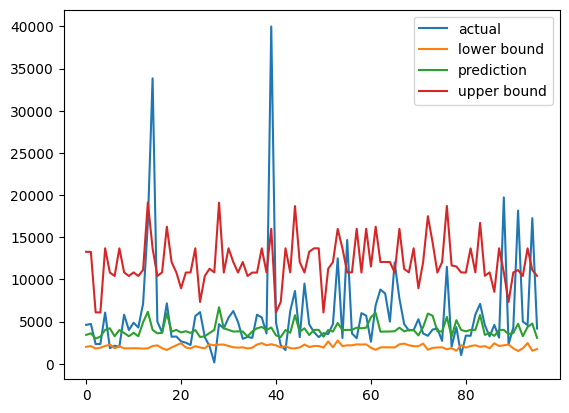

In [182]:
_ = plt.plot(test_encoded["target"], label="actual")
_ = plt.plot(pred[:, 0], label="lower bound")
_ = plt.plot(pred[:, 1], label="prediction")
_ = plt.plot(pred[:, 2], label="upper bound")
_ = plt.legend()

### Conformal prediction

Conformal prediction [[2]]() is a way to generate prediction sets for any model for free without modification needed. This method can construct the prediction set that satisfies the following

<!-- Equation -->
$$
1 - \alpha \le \mathbb{P}(Y_{test} \in C(X_{test})) \le 1 - \alpha + \frac{1}{n+1}
$$

where,

$\alpha$ is the error rate

$C(X_{test})$ is the prediction set

There are 3 steps to perform this method:

* Get the score $s$ (Larger scores encode worse agreement between x and y)
* Find the quantile of the score $\hat{q}$
* Form the prediction set $C(X_{test}) = \{y: s(X_{test}, y) \le \hat{q}\}$

In [57]:
mean_scores, best_model = rollout_result(
    model_fn=lambda: CatBoostClassifier(iterations=1e3, depth=5, verbose=0),
    df=df_copy,
    cat_features=["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area"],
    num_features=[],
    target="ApplicantIncomeBin",
    use_onehot=True
)

In [58]:
mean_scores

0.3291666666666667

In [105]:
train, test = train_test_split(df_copy, test_size=0.2, random_state=123)

train_encoded, encoder = encode_categorical_features_v2(
    train, 
    ["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area"]
)

train_encoded["target"] = train["ApplicantIncomeBin"].reset_index(drop=True)

In [106]:
model = CatBoostClassifier(iterations=1e3, depth=5, verbose=0)
model.fit(
    train_encoded.drop("target", axis=1), 
    train_encoded["target"]
)

In [107]:
test_encoded = apply_encoder(test, encoder, ["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area"])

test_encoded["target"] = test["ApplicantIncomeBin"].reset_index(drop=True)

In [108]:
print(
    classification_report(
        test_encoded["target"],
        model.predict(test_encoded.drop("target", axis=1)),
        labels=applicant_income_bin_names
    )
)

               precision    recall  f1-score   support

      <= 2500       0.20      0.07      0.11        14
 (2500, 3500]       0.15      0.28      0.19        18
 (3500, 6000]       0.38      0.37      0.37        41
(6000, 17000]       0.24      0.22      0.23        18
      > 17000       0.00      0.00      0.00         5

     accuracy                           0.26        96
    macro avg       0.19      0.19      0.18        96
 weighted avg       0.26      0.26      0.25        96



/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and b

In [109]:
pd.DataFrame(
    confusion_matrix(
        test_encoded["target"],
        model.predict(test_encoded.drop("target", axis=1)),
        labels=applicant_income_bin_names
    ),
    index=applicant_income_bin_names,
    columns=applicant_income_bin_names
)

,<= 2500,"(2500, 3500]","(3500, 6000]","(6000, 17000]",> 17000
<= 2500,1,5,4,4,0
"(2500, 3500]",3,5,9,1,0
"(3500, 6000]",1,17,15,8,0
"(6000, 17000]",0,4,10,4,0
> 17000,0,3,2,0,0


Each $i^{th}$ row represents the true label while each $j^{th}$ column represents the prediction.

From this confusion matrix, we can interpret the result in terms of overprediction and underprediction. Where, the overprediction for class $i^{th}$ will be any $j^{th} > i^{th}$. Inversely, underprediction for class $i^{th}$ will be any $j^{th} < i^{th}$.

Bank will take lower risk for underprediction as we estimate their income less than what actually is. However, we lost the opportunity to gain more profit.

**Split the data into 3 sets (train, calibrate, test)**

In [64]:
from imblearn.over_sampling import SMOTE

In [65]:
df_copy["ApplicantIncomeBin"].value_counts()

(3500, 6000]     164
(2500, 3500]     121
(6000, 17000]    100
<= 2500           83
> 17000           12
Name: ApplicantIncomeBin, dtype: int64

In [66]:
df_encoded, encoder = encode_categorical_features_v2(
    df=df_copy, 
    feature_cols=["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area"], 
    target_col=None
)

df_encoded["target"] = df_copy["ApplicantIncomeBin"].reset_index(drop=True)

# X, y = SMOTE().fit_resample(df_encoded.drop("target", axis=1), df_encoded["target"])

In [67]:
# df_encoded = X.copy()
# df_encoded["target"] = y

In [112]:
train, test = train_test_split(df_encoded, test_size=0.2, random_state=123)  # 80, 20
train, calibrate = train_test_split(train, test_size=0.3, random_state=123)

In [113]:
df_copy.shape, train.shape, calibrate.shape, test.shape

((480, 19), (268, 16), (116, 16), (96, 16))

**Training the model**

In [114]:
model = CatBoostClassifier(verbose=0)

model.fit(train.drop("target", axis=1), train["target"])

In [115]:
calibrate_label_index = calibrate["target"].map(lambda x: list(model.classes_).index(x))

**Conformal prediction**

In [120]:
alpha = 0.1
n = calibrate.shape[0]

scores = 1 - model.predict_proba(calibrate.drop("target", axis=1))[np.arange(n), calibrate_label_index]
q_level = np.ceil((n+1) * (1-alpha)) / n
qhat = np.quantile(scores, q_level, method="higher")

In [121]:
prob_pred = model.predict_proba(test.drop("target", axis=1))

<AxesSubplot: ylabel='Count'>

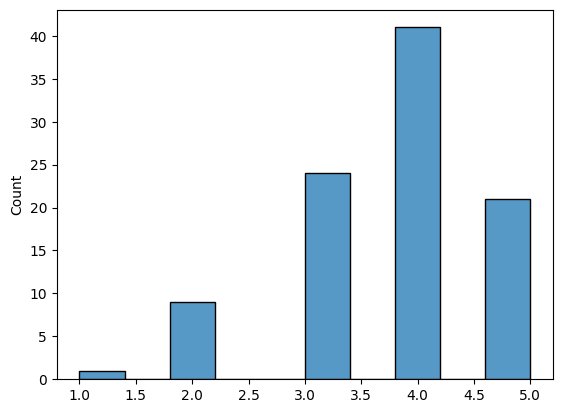

In [122]:
sns.histplot(list(map(lambda x: len(model.classes_[x]), prob_pred >= (1-qhat))))

In [136]:
from pprint import pprint

In [141]:
res = []

for i, x in enumerate(list(map(lambda x: model.classes_[x], prob_pred >= (1-qhat)))):
    print(x, test.iloc[i, -1], sep="|")
    res.append(
        test.iloc[i, -1] in x
    )

['(2500, 3500]' '(6000, 17000]' '<= 2500' '> 17000']|(3500, 6000]
['(2500, 3500]' '(3500, 6000]' '> 17000']|(3500, 6000]
['(2500, 3500]' '(6000, 17000]' '<= 2500']|<= 2500
['(2500, 3500]' '(3500, 6000]' '(6000, 17000]' '<= 2500']|<= 2500
['(2500, 3500]' '(6000, 17000]' '<= 2500']|(6000, 17000]
['(2500, 3500]' '(3500, 6000]' '(6000, 17000]' '> 17000']|<= 2500
['(2500, 3500]' '(3500, 6000]' '(6000, 17000]']|<= 2500
['(2500, 3500]' '(3500, 6000]' '(6000, 17000]' '<= 2500' '> 17000']|<= 2500
['(2500, 3500]' '(3500, 6000]' '(6000, 17000]' '<= 2500']|(3500, 6000]
['(2500, 3500]' '(3500, 6000]' '(6000, 17000]']|(3500, 6000]
['(2500, 3500]' '(3500, 6000]' '(6000, 17000]' '<= 2500']|(3500, 6000]
['(2500, 3500]' '(3500, 6000]' '(6000, 17000]']|(3500, 6000]
['(2500, 3500]' '(3500, 6000]' '(6000, 17000]' '<= 2500' '> 17000']|(6000, 17000]
['(2500, 3500]' '(3500, 6000]' '(6000, 17000]' '<= 2500' '> 17000']|(6000, 17000]
['(2500, 3500]' '(6000, 17000]' '<= 2500']|> 17000
['(2500, 3500]' '(3500, 6000

In [124]:
np.mean(res)

0.875

# References

1. [Loan Prediction w/ Various ML Models](https://www.kaggle.com/code/caesarmario/loan-prediction-w-various-ml-models/notebook)
2. [A Gentle Introduction to Conformal Prediction and Distribution-Free Uncertainty Quantification](https://arxiv.org/abs/2107.07511)
3. [Mortgage Calculator](https://www.bankrate.com/mortgages/mortgage-calculator/)